In [1]:
import sys
sys.path.append("../")
from src.utils.wandb_utils import get_config, config_to_omegaconf

%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [3]:
user = "kealexanderwang"
project = "importance-reweighing"

run_names = [
    "fluent-field-198", # SimCLR on full waterbirds
]

query = {"displayName": {"$in": run_names}}

In [4]:
from typing import Tuple
device = "cuda"

def init_model(name_config: Tuple[str, dict], ckpt_name="last.ckpt"):
    
    name, config = name_config
    config = config_to_omegaconf(config)
    run_dir = config["run_dir"]
    
    config.trainer.gpus = 0  # don't use GPU for test time
    from src.train import hydra_init
    hydra_objs = hydra_init(config)
    
    model = hydra_objs.model
    model.eval()
    model.to(device)
    
    datamodule = hydra_objs.datamodule
    datamodule.setup()
    return model, datamodule

In [5]:
name_configs = get_config(user=user, project=project, query=query)

In [6]:
model_datamodule_lst = [init_model(name_config) for name_config in name_configs]

<class 'src.pl_models.imbalanced_classifier_model.ImbalancedClassifierModel'> initialized with unused kwargs: ['params_total', 'params_trainable', 'params_not_trainable']
Resetting final linear layer
Freezing feature extractor


GPU available: True, used: False
TPU available: False, using: 0 TPU cores
/u/nlp/anaconda/main/anaconda3/envs/is/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)


Train class counts: Counter({0: 3682, 1: 1113})
Train group counts: Counter({0: 3498, 3: 1057, 1: 184, 2: 56})
Val class counts: Counter({0: 933, 1: 266})
Val group counts: Counter({0: 467, 1: 466, 3: 133, 2: 133})
Test class counts: Counter({0: 4510, 1: 1284})
Test group counts: Counter({0: 2255, 1: 2255, 3: 642, 2: 642})


In [7]:
model, datamodule = model_datamodule_lst[0]

In [8]:
feature_extractor = lambda x: model.architecture._forward_impl(x, apply_fc=False)

In [9]:
dataset = datamodule.val_dataset

In [15]:
import torch
#num_subset = 1000
num_subset = len(dataset)
torch.manual_seed(0)
subset = torch.randperm(len(dataset))[:num_subset]

In [16]:
X = torch.stack([dataset[i].x for i in subset])

In [17]:
Y = [dataset[i].y for i in subset]
G = [dataset[i].g for i in subset]

In [18]:
with torch.no_grad():
    chunks = torch.chunk(X, 10, dim=0)
    Z = torch.cat([feature_extractor(c.to(device)) for c in chunks])

In [19]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

pca = PCA(n_components=2)
Z_pca = pca.fit_transform(Z.cpu().numpy())

lda = LinearDiscriminantAnalysis()
Z_lda = lda.fit_transform(Z.cpu().numpy(), Y)

group_lda = LinearDiscriminantAnalysis()
Z_group_lda = lda.fit_transform(Z.cpu().numpy(), G)

In [20]:
pca.singular_values_

array([11208.294  ,   656.59595], dtype=float32)

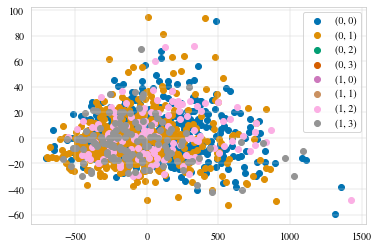

In [21]:
from itertools import product

fig, ax = plt.subplots()
for y, g in product(np.unique(Y), np.unique(G)):
    ix = np.where((G == g) * (Y == y))
    ax.scatter(*Z_pca[ix].T, label=f"{y,g}")
ax.legend()

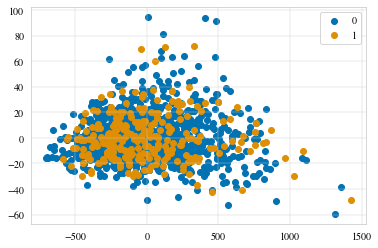

In [22]:
from itertools import product

fig, ax = plt.subplots()
for y in np.unique(Y):
    ix = np.where(Y == y)
    ax.scatter(*Z_pca[ix].T, label=f"{y}")
ax.legend()

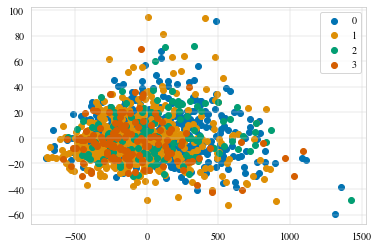

In [23]:
from itertools import product

fig, ax = plt.subplots()
for g in np.unique(G):
    ix = np.where(G == g)
    ax.scatter(*Z_pca[ix].T, label=f"{g}")
ax.legend()

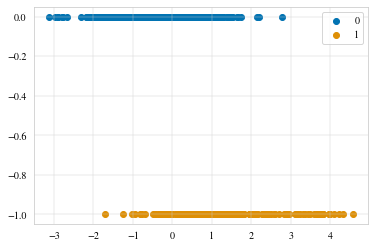

In [24]:
from itertools import product

fig, ax = plt.subplots()
for y in np.unique(Y):
    ix = np.where(Y == y)
    ax.scatter(Z_lda[ix, :], -y * np.ones(Z_lda[ix].shape[0]), label=f"{y}")
ax.legend()

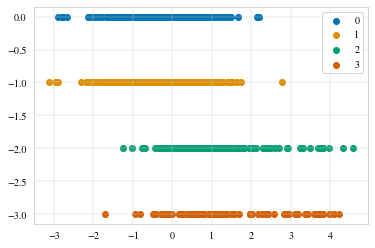

In [25]:
from itertools import product

fig, ax = plt.subplots()
for g in np.unique(G):
    ix = np.where(G == g)
    ax.scatter(Z_lda[ix, :], -g * np.ones(Z_lda[ix].shape[0]), label=f"{g}")
ax.legend()

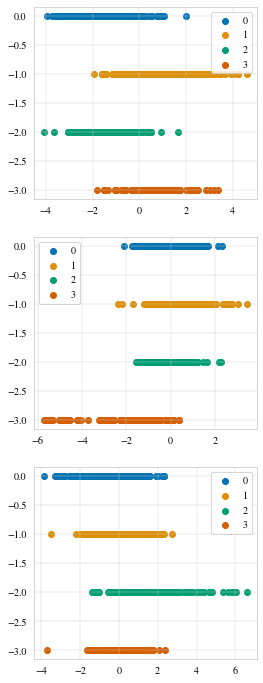

In [26]:
from itertools import product

n_axes = len(np.unique(G)) - 1
fig, axes = plt.subplots(nrows=n_axes, figsize=(4, 4 * n_axes))

for g in np.unique(G):
    for i, ax in enumerate(axes):
        ix = np.where(G == g)
        ax.scatter(Z_group_lda[ix, i], -g * np.ones(Z_group_lda[ix].shape[0]), label=f"{g}")
        ax.legend()